In [8]:
import torch
from torch import nn

import numpy as np
import pandas as pd
from scipy.stats import norm
from urllib.request import urlopen

from torch.distributions.constraints import positive

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.contrib.oed.eig import marginal_eig

import matplotlib.pyplot as plt

In [3]:
N = 2000 # total number of points
p = 8 # num of samples per each axis of (t_1, t_2)

x = np.linspace(0, N, p, endpoint=False)
y = np.linspace(0, N, p, endpoint=False)
x2D,y2D = np.meshgrid(x,y)
indices = np.stack((x2D,y2D),axis=2).reshape(-1,2).astype(int)
times = np.linspace(0,2*np.pi,N)

designs = torch.tensor(times[indices])
#designs = torch.tensor(indices)
print(designs.shape[-2:])

torch.Size([64, 2])


In [4]:
w_1 = torch.tensor(1.0)
w_2 = torch.tensor(3.0)
sigma = torch.tensor(0.1)

def model(t):
    w = pyro.sample("w", dist.Uniform(w_1,w_2))
    phase = pyro.sample("phase", dist.Uniform(np.pi/2, 3*np.pi/2))
    with pyro.plate_stack("plate", t.shape[:-1]): 
        y_true = torch.sin(w*t+phase)
        return pyro.sample("y", dist.Normal(y_true,sigma).to_event(1))

In [5]:
def marginal_guide(design, observation_labels, target_labels):
    marg_mean = pyro.param("marg_mean", torch.ones(design.shape))
    marg_sd = pyro.param("marg_sd", torch.ones(design.shape), constraint=positive)
    pyro.sample("y", dist.Normal(marg_mean, marg_sd).to_event(1))

In [6]:
pyro.clear_param_store()
num_steps, start_lr, end_lr = 1000, 0.1, 0.001
optimizer = pyro.optim.ExponentialLR({'optimizer': torch.optim.Adam,
                                      'optim_args': {'lr': start_lr},
                                      'gamma': (end_lr / start_lr) ** (1 / num_steps)})

marginal_eig_output = marginal_eig(model,
                   designs,                 # tensor of possible designs
                   "y",                     # observation labels
                   ["w", "phase"],          # target (parameter) labels
                   num_samples=2000,         # number of samples to draw per step in the expectation
                   num_steps=num_steps,     # number of gradient steps
                   guide=marginal_guide,   # guide q(y)
                   optim=optimizer,         # optimizer with learning rate decay
                   ) 

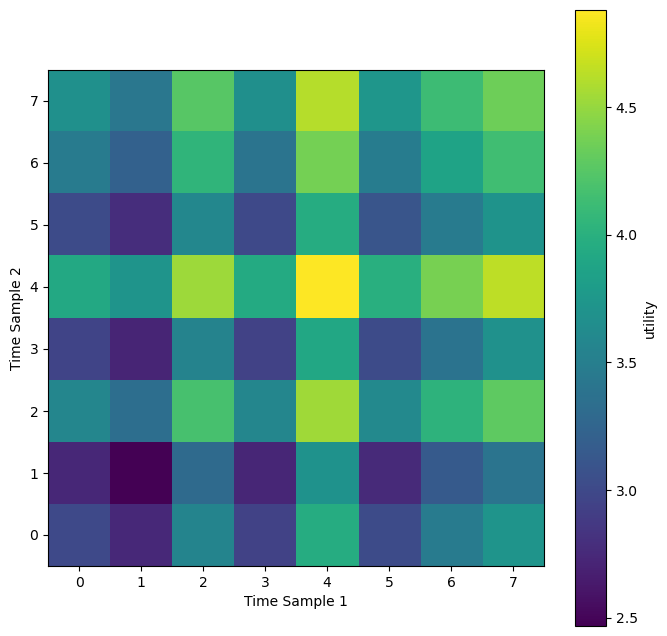

In [9]:
plt.figure(figsize=(8,8))
img_2D = plt.imshow(marginal_eig_output.detach().numpy().reshape(p,p), origin="lower")
cbar = plt.colorbar(img_2D)
cbar.set_label("utility")
plt.xlabel("Time Sample 1")
plt.ylabel("Time Sample 2")
plt.show()